

---


---



**Inference Code**

---

---





<ipython-input-18-ba0ba9180d63>:425: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location=device)


Saved image: output_images/DDR2_sample_1.png
Saved image: output_images/DDR2_sample_2.png
Saved image: output_images/DDR2_sample_3.png
Saved image: output_images/DDR2_sample_4.png
Saved image: output_images/DDR2_sample_5.png
Saved image: output_images/DDR2_sample_6.png
Saved image: output_images/DDR2_sample_7.png
Saved image: output_images/DDR2_sample_8.png

Displaying generated images:


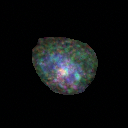

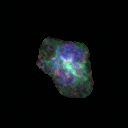

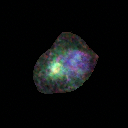

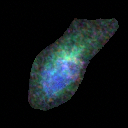

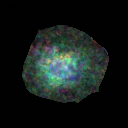

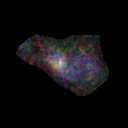

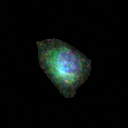

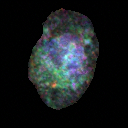

In [18]:


import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
from IPython.display import Image, display
from einops import rearrange
from torch import einsum

#############################################
# Model and Utility Definitions
#############################################

def get_num_groups(num_channels):
    for num_groups in [32, 16, 8, 4, 2, 1]:
        if num_channels % num_groups == 0:
            return num_groups
    return 1

class PositionalEncoding2D(nn.Module):
    def __init__(self, channels):
        super(PositionalEncoding2D, self).__init__()
        if channels % 4 != 0:
            raise ValueError("Channels must be divisible by 4")
        self.channels = channels

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        device = x.device
        num_pos_feats = channels // 2

        y_embed = torch.linspace(-1, 1, height, device=device).unsqueeze(1).repeat(1, width)
        x_embed = torch.linspace(-1, 1, width, device=device).unsqueeze(0).repeat(height, 1)

        dim_t = torch.arange(num_pos_feats // 2, dtype=torch.float32, device=device)
        dim_t = 10000 ** (2 * (dim_t // 2) / num_pos_feats)

        pos_x = x_embed.unsqueeze(-1) / dim_t
        pos_y = y_embed.unsqueeze(-1) / dim_t

        pos_x = torch.stack((pos_x.sin(), pos_x.cos()), dim=-1).view(height, width, -1)
        pos_y = torch.stack((pos_y.sin(), pos_y.cos()), dim=-1).view(height, width, -1)

        pos_emb = torch.cat((pos_y, pos_x), dim=-1)
        pos_emb = pos_emb.permute(2, 0, 1).unsqueeze(0).repeat(batch_size, 1, 1, 1)
        return pos_emb

class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_res=True):
        super().__init__()
        self.same_channels = in_channels == out_channels
        self.is_res = is_res

        num_groups_in = get_num_groups(in_channels)
        num_groups_out = get_num_groups(out_channels)

        self.norm1 = nn.GroupNorm(num_groups_in, in_channels)
        self.act1 = nn.GELU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)

        self.norm2 = nn.GroupNorm(num_groups_out, out_channels)
        self.act2 = nn.GELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)

        if not self.same_channels:
            self.conv1x1 = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        identity = x
        out = self.norm1(x)
        out = self.act1(out)
        out = self.conv1(out)
        out = self.norm2(out)
        out = self.act2(out)
        out = self.conv2(out)
        if self.is_res:
            if not self.same_channels:
                identity = self.conv1x1(identity)
            out += identity
            out = out / 1.414
        return out

class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        self.conv = nn.Sequential(
            ResidualConvBlock(in_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        )
        self.down = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv(x)
        x_down = self.down(x)
        return x_down, x  # For skip connections

class UnetUp(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(UnetUp, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(get_num_groups(out_channels), out_channels),
            nn.GELU(),
        )
        self.conv = nn.Sequential(
            ResidualConvBlock(out_channels + skip_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        )

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='nearest')
        x = torch.cat((x, skip), dim=1)
        x = self.conv(x)
        return x

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        )

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, window_size=(16, 16), heads=8, shifted=False):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.window_size = window_size
        self.head_dim = dim // heads
        self.scale = self.head_dim ** -0.5
        self.shifted = shifted

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

        num_relative_distance = (2 * window_size[0] - 1) * (2 * window_size[1] - 1)
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros(num_relative_distance, heads)
        )

        coords_h = torch.arange(window_size[0])
        coords_w = torch.arange(window_size[1])
        coords = torch.stack(torch.meshgrid(coords_h, coords_w))
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += window_size[0] - 1
        relative_coords[:, :, 1] += window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)

        nn.init.trunc_normal_(self.relative_position_bias_table, std=0.02)

    def forward(self, x, mask=None):
        B, C, H, W = x.shape
        window_h, window_w = self.window_size
        shifted = self.shifted

        if shifted:
            shift_size_h = window_h // 2
            shift_size_w = window_w // 2
            x = torch.roll(x, shifts=(-shift_size_h, -shift_size_w), dims=(2, 3))
        else:
            shift_size_h = 0
            shift_size_w = 0

        pad_h = (window_h - H % window_h) if H % window_h != 0 else 0
        pad_w = (window_w - W % window_w) if W % window_w != 0 else 0
        x = F.pad(x, (0, pad_w, 0, pad_h))
        B, C, H_padded, W_padded = x.shape

        if shifted:
            img_mask = torch.zeros((1, H_padded, W_padded, 1), device=x.device)
            h_blocks = H_padded // window_h
            w_blocks = W_padded // window_w
            cnt = 0
            for h in range(h_blocks):
                for w in range(w_blocks):
                    img_mask[:, h*window_h:(h+1)*window_h, w*window_w:(w+1)*window_w, :] = cnt
                    cnt += 1
            mask_windows = self.window_partition(img_mask.permute(0, 3, 1, 2), window_h, window_w)
            mask_windows = mask_windows.squeeze(-1)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        x_windows = self.window_partition(x, window_h, window_w)
        qkv = self.to_qkv(x_windows).reshape(x_windows.shape[0], x_windows.shape[1], 3, self.heads, self.head_dim)
        q, k, v = qkv.permute(2, 0, 3, 1, 4).unbind(0)
        attn = (q @ k.transpose(-2, -1)) * self.scale

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            window_h * window_w, window_h * window_w, -1
        )
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        if shifted:
            attn = attn.view(B, -1, self.heads, window_h * window_w, window_h * window_w)
            attn = attn + attn_mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.heads, window_h * window_w, window_h * window_w)
            attn = attn.softmax(dim=-1)
        else:
            attn = attn.softmax(dim=-1)

        out = (attn @ v).transpose(1, 2).reshape(x_windows.shape[0], window_h * window_w, C)
        out = self.to_out(out)
        out = out.view(-1, window_h, window_w, C)
        x = self.window_reverse(out, H_padded, W_padded, window_h, window_w)
        if shifted:
            x = torch.roll(x, shifts=(shift_size_h, shift_size_w), dims=(2, 3))
        if pad_h > 0 or pad_w > 0:
            x = x[:, :, :H, :W]
        return x

    def window_partition(self, x, window_h, window_w):
        B, C, H, W = x.shape
        x = x.view(B, C, H // window_h, window_h, W // window_w, window_w)
        x = x.permute(0, 2, 4, 3, 5, 1).contiguous().view(-1, window_h * window_w, C)
        return x

    def window_reverse(self, windows, H, W, window_h, window_w):
        B = int(windows.shape[0] / (H * W / (window_h * window_w)))
        x = windows.view(B, H // window_h, W // window_w, window_h, window_w, -1)
        x = x.permute(0, 5, 1, 3, 2, 4).contiguous().view(B, -1, H, W)
        return x

class MultiHeadCrossAttention(nn.Module):
    def __init__(self, dim, context_dim, heads=1, dim_head=None):
        super().__init__()
        self.dim = dim
        self.context_dim = context_dim
        self.heads = heads
        self.dim_head = dim_head or (dim // heads)
        inner_dim = self.dim_head * heads
        self.scale = self.dim_head ** -0.5

        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_k = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x, context):
        b, c, h, w = x.shape
        x = x.view(b, c, -1).permute(0, 2, 1)
        q = self.to_q(x)
        k = self.to_k(context).unsqueeze(1)
        v = self.to_v(context).unsqueeze(1)
        q = q.view(b, -1, self.heads, self.dim_head).transpose(1, 2)
        k = k.view(b, -1, self.heads, self.dim_head).transpose(1, 2)
        v = v.view(b, -1, self.heads, self.dim_head).transpose(1, 2)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-2)
        out = (attn @ v).transpose(1, 2).reshape(b, -1, self.dim)
        out = self.to_out(out)
        out = out.permute(0, 2, 1).view(b, c, h, w)
        return out

class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=64, n_cfeat=1536):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat

        # Encoder
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, 2 * n_feat)
        self.down2 = UnetDown(2 * n_feat, 4 * n_feat)
        self.down3 = UnetDown(4 * n_feat, 8 * n_feat)
        self.to_vec = nn.Identity()

        # Embeddings for time and context
        self.timeembed1 = EmbedFC(1, 8 * n_feat)
        self.timeembed2 = EmbedFC(1, 4 * n_feat)
        self.timeembed3 = EmbedFC(1, 2 * n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 8 * n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 4 * n_feat)
        self.contextembed3 = EmbedFC(n_cfeat, 2 * n_feat)

        # Decoder
        self.up0 = nn.Sequential(
            ResidualConvBlock(8 * n_feat, 8 * n_feat),
            ResidualConvBlock(8 * n_feat, 8 * n_feat),
        )
        self.up1 = UnetUp(in_channels=8 * n_feat, skip_channels=8 * n_feat, out_channels=4 * n_feat)
        self.up2 = UnetUp(in_channels=4 * n_feat, skip_channels=4 * n_feat, out_channels=2 * n_feat)
        self.up3 = UnetUp(in_channels=2 * n_feat, skip_channels=2 * n_feat, out_channels=n_feat)
        self.out = nn.Conv2d(n_feat, self.in_channels, 3, 1, 1)

        # Attention layers
        self.self_attn1 = MultiHeadSelfAttention(dim=8 * n_feat, window_size=(8, 8), heads=8, shifted=False)
        self.self_attn2 = MultiHeadSelfAttention(dim=4 * n_feat, window_size=(4, 4), heads=8, shifted=True)
        self.self_attn3 = MultiHeadSelfAttention(dim=2 * n_feat, window_size=(2, 2), heads=8, shifted=False)
        self.cross_attn1 = MultiHeadCrossAttention(dim=8 * n_feat, context_dim=8 * n_feat, heads=1)
        self.cross_attn2 = MultiHeadCrossAttention(dim=4 * n_feat, context_dim=4 * n_feat, heads=1)
        self.cross_attn3 = MultiHeadCrossAttention(dim=2 * n_feat, context_dim=2 * n_feat, heads=1)

        self.pos_encoding = PositionalEncoding2D(n_feat)
        self.shift = False

    def forward(self, x, t, c=None):
        x = self.init_conv(x)
        x = x + self.pos_encoding(x)
        down1, skip1 = self.down1(x)
        down2, skip2 = self.down2(down1)
        down3, skip3 = self.down3(down2)
        hiddenvec = self.to_vec(down3)

        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x.device)

        c_embed1 = self.contextembed1(c).unsqueeze(-1).unsqueeze(-1)
        c_embed2 = self.contextembed2(c).unsqueeze(-1).unsqueeze(-1)
        c_embed3 = self.contextembed3(c).unsqueeze(-1).unsqueeze(-1)

        temb1 = self.timeembed1(t).unsqueeze(-1).unsqueeze(-1)
        temb2 = self.timeembed2(t).unsqueeze(-1).unsqueeze(-1)
        temb3 = self.timeembed3(t).unsqueeze(-1).unsqueeze(-1)

        up1 = self.up0(hiddenvec)
        up1 = self.self_attn1(up1)
        up1 = self.cross_attn1(up1, c_embed1.squeeze(-1).squeeze(-1))
        up1 = up1 + temb1
        up1 = self.up1(up1, skip3)

        up2 = self.self_attn2(up1)
        up2 = self.cross_attn2(up2, c_embed2.squeeze(-1).squeeze(-1))
        up2 = up2 + temb2
        up2 = self.up2(up2, skip2)

        up3 = self.self_attn3(up2)
        up3 = self.cross_attn3(up3, c_embed3.squeeze(-1).squeeze(-1))
        up3 = up3 + temb3
        up3 = self.up3(up3, skip1)

        out = self.out(up3)
        return out

#############################################
# Diffusion Sampling Functions and Hyperparameters
#############################################

# Diffusion hyperparameters
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_feat = 128
n_cfeat = 1536
height = 128

b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps+1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

@torch.no_grad()
def sample_ddpm_context(n_sample, context, model):
    samples = torch.randn(n_sample, 3, height, height).to(device)
    for i in range(timesteps, 0, -1):
        print(f'Sampling timestep {i}/{timesteps}', end='\r')
        # Create a tensor of shape (n_sample, 1, 1, 1) filled with i/timesteps
        t = torch.full((n_sample, 1, 1, 1), i / timesteps, device=device)
        z = torch.randn_like(samples) if i > 1 else 0
        if isinstance(model, nn.DataParallel):
            eps = model(samples, t, context)
        else:
            eps = model(samples, t, c=context)
        samples = denoise_add_noise(samples, i, eps, z)
    return samples

#############################################
# Inference Function for Jupyter
#############################################

def run_inference(gene_name, checkpoint, embedding_pickle, output_dir='output_images'):
    """
    Runs inference in a Jupyter Notebook.

    Parameters:
      - gene_name (str): Gene name to use for condition embedding.
      - checkpoint (str): Path to model checkpoint file.
      - embedding_pickle (str): Path to gene embedding pickle file.
      - output_dir (str): Directory to save generated images.
    """
    # Load gene embeddings
    with open(embedding_pickle, 'rb') as fp:
        gene_embeddings = pickle.load(fp)

    if gene_name not in gene_embeddings:
        print(f"Gene {gene_name} not found in embeddings.")
        return

    # Prepare the gene embedding (context) for 8 samples
    gene_embedding = gene_embeddings[gene_name]
    gene_embedding = torch.tensor(gene_embedding, dtype=torch.float32, device=device).unsqueeze(0)
    context = gene_embedding.repeat(8, 1)

    # Initialize the model
    model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat).to(device)

    # Load checkpoint and remove 'module.' prefix if present
    state_dict = torch.load(checkpoint, map_location=device)
    new_state_dict = {k.replace("module.", "") if k.startswith("module.") else k: v
                      for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    model.eval()

    os.makedirs(output_dir, exist_ok=True)

    # Generate samples via the diffusion reverse process
    samples = sample_ddpm_context(8, context, model)
    samples = (samples.clamp(-1, 1) + 1) / 2  # Normalize to [0, 1]

    # Save and display generated images
    image_paths = []
    for i in range(8):
        save_path = os.path.join(output_dir, f"{gene_name}_sample_{i+1}.png")
        save_image(samples[i], save_path)
        image_paths.append(save_path)
        print(f"Saved image: {save_path}")

    # Display images inline
    print("\nDisplaying generated images:")
    for path in image_paths:
        display(Image(filename=path))


# Set parameters and run inference (adjust paths as needed)
gene_name = "DDR2"  # Replace with your gene of interest
checkpoint = "/content/drive/MyDrive/cellclub/image-generation-project/latest_diffusion/context_model_13.pth"  # Replace with your checkpoint path
embedding_pickle = "/content/drive/MyDrive/cellclub/image-generation-project/GenePT_gene_embedding_ada_text.pickle"
output_dir = "output_images"  # Directory where images will be saved

# Run the inference function
run_inference(gene_name, checkpoint, embedding_pickle, output_dir)
